<a href="https://colab.research.google.com/github/dilp90/Artificial_Intelligence_FIME/blob/main/Procesamiento_a_color/PDI_SegmentacionOptima_RGB_a_EscGrises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentación simple y segmentación óptima**

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize # para algoritmo de optimización

## **Segmentación sencilla**

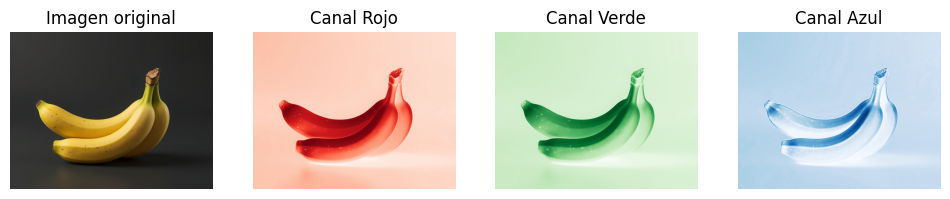

In [3]:
# Cargar imagen a color
img = cv2.imread('/content/platano.jpg')  # Cambia 'imagen.jpg' por la ruta de tu imagen
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR (OpenCV) a RGB

# Separar canales
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

# Mostrar los canales por separado
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(R, cmap='Reds')
plt.title('Canal Rojo')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(G, cmap='Greens')
plt.title('Canal Verde')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(B, cmap='Blues')
plt.title('Canal Azul')
plt.axis('off')
plt.show()

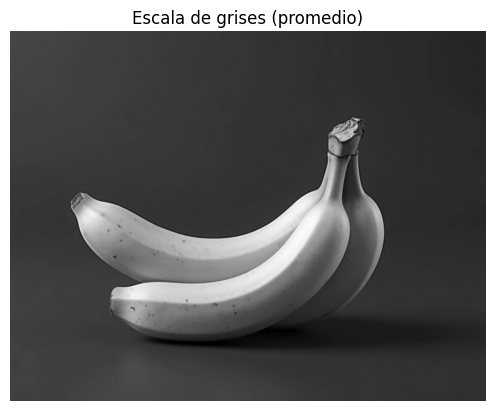

In [4]:
# Convertir a escala de grises promediando canales
gray_avg = ((R.astype(np.float32) + G + B) / 3).astype(np.uint8)

# Mostrar imagen en escala de grises
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')
plt.show()

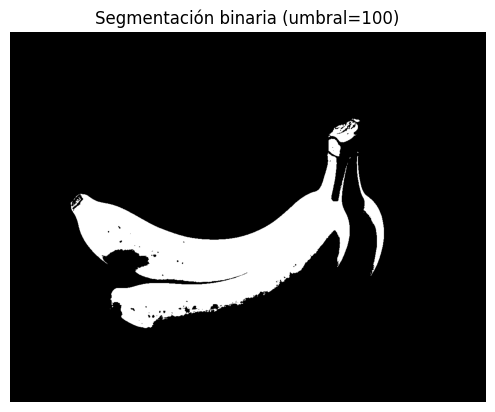

In [5]:
# Umbral para segmentación
umbral = 100
_, segmentada = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)

# Mostrar imagen segmentada
plt.imshow(segmentada, cmap='gray')
plt.title(f'Segmentación binaria (umbral={umbral})')
plt.axis('off')
plt.show()

## **Segmentación óptima**

Objetivo:
Encontrar los coeficientes óptimos
[w_𝑟, 𝑤_𝑔, 𝑤_𝑏] para convertir una imagen RGB a escala de grises usando:

Gris(i,j)=w_r​⋅R(i,j)+w_g⋅G(i,j)+w_b⋅B(i,j)

Bajo la restricción: w_𝑟 + 𝑤_𝑔 + 𝑤_𝑏 = 1

El criterio de optimización es: Maximizar la varianza de la imagen en escala de grises normalizada (mayor varianza ≡ mayor contraste).

In [7]:
# Cargar imagen y convertir de BGR a RGB
img = cv2.imread('/content/platano.jpg')  # Cambia el nombre de la imagen
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

1. Función `grayscale_variance`:

* Aquí se crea la imagen en escala de grises combinando los canales RGB normalizados.

* Después se normaliza la imagen gris resultante para que sus valores estén entre 0 y 1. Esto es importante para que la varianza sea comparable entre distintas combinaciones de pesos.

* Finalmente se regresa la varianza negativa de la imagen en escala de grises. ¿Por qué el signo negativo? porque la función `minimize()` de `scipy.optimize` minimiza un valor. Pero aquí necesitamos maximizar el contraste (es decir, la varianza). Entonces:  para maximizar varianza, invertimos el valor: -varianza.

¿Por qué usamos varianza para contraste?

La varianza mide la dispersión de los niveles de gris:

* Si todos los píxeles están cerca del mismo valor → baja varianza (imagen plana).

* Si hay muchos valores oscuros y claros → alta varianza (imagen con contraste).

Entonces, máxima varianza → mejor contraste.

2. Función `minimize` de `scipy.optimize`:

Objetivo: busca el mínimo de una función objetivo (en este caso, *la varianza negativa* de la imagen en grises)

Argumentos:

* `grayscale_variance`:
Esta es la función objetivo. Como ya vimos, devuelve la varianza negativa de la imagen en grises para un conjunto de pesos RGB.

* `initial_weights`:
Es el punto de partida del algoritmo. Aquí empezamos con `[0.33, 0.33, 0.34]`, que es casi igual para los tres canales.

* `method='SLSQP'`:
Es el método de optimización.
SLSQP = Sequential Least Squares Programming, el cual es bueno cuando:

  * Hay restricciones (como suma de pesos = 1).

  * Hay límites en las variables (como pesos entre 0 y 1).

* `bounds=bounds`: Define los límites para cada peso, en este caso: [(0,1), (0,1), (0,1)]

* `constraints=constraints`:
Son las restricciones adicionales. En este caso, aseguramos que la suma de los coeficientes sea siempre 1.

In [8]:
# Normalizar canales entre 0 y 1
R_norm = R.astype(np.float32) / 255
G_norm = G.astype(np.float32) / 255
B_norm = B.astype(np.float32) / 255

# Función objetivo: varianza negativa (porque minimize() minimiza)
def grayscale_variance(weights):
    w_r, w_g, w_b = weights
    gray = w_r * R_norm + w_g * G_norm + w_b * B_norm
    gray_normalized = (gray - gray.min()) / (gray.max() - gray.min())
    return -np.var(gray_normalized)  # Negativo para maximizar

# Restricción: suma de pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Límites de cada peso: entre 0 y 1
bounds = [(0, 1), (0, 1), (0, 1)]

# Valor inicial
initial_weights = [0.33, 0.33, 0.34]

# Optimización
result = minimize(grayscale_variance, initial_weights, method='SLSQP',
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Pesos óptimos:", optimal_weights)

Pesos óptimos: [1.00000000e+00 0.00000000e+00 2.22044605e-16]


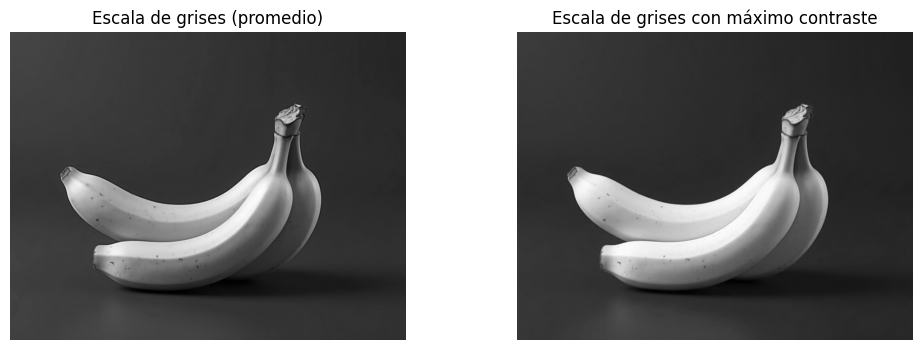

In [10]:
# Crear imagen en escala de grises con pesos óptimos
gray_optimal = optimal_weights[0] * R_norm + optimal_weights[1] * G_norm + optimal_weights[2] * B_norm
gray_optimal = (gray_optimal * 255).astype(np.uint8)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(gray_optimal, cmap='gray')
plt.title('Escala de grises con máximo contraste')
plt.axis('off')
plt.show()

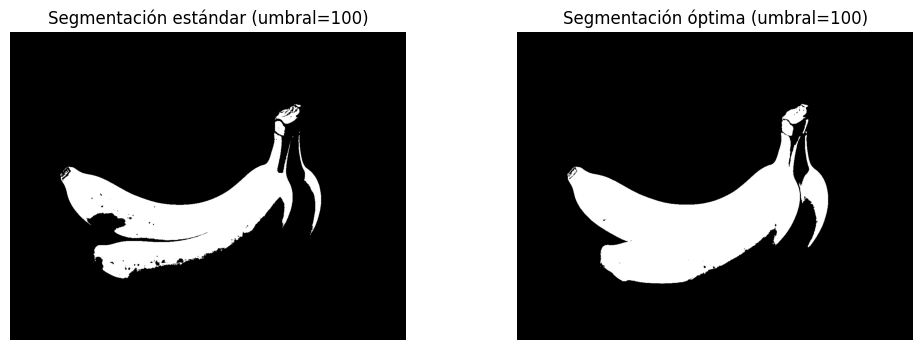

In [19]:
# Segmentar ambas imágenes con un mismo umbral
umbral = 100
_, seg_standard = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)
_, seg_optimal = cv2.threshold(gray_optimal, umbral, 255, cv2.THRESH_BINARY)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(seg_standard, cmap='gray')
plt.title(f'Segmentación estándar (umbral={umbral})')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(seg_optimal, cmap='gray')
plt.title(f'Segmentación óptima (umbral={umbral})')
plt.axis('off')
plt.show()